In [1]:
import intake
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from dask.distributed import Client
import matplotlib.colors as col
import matplotlib.gridspec as gs
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize


from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client(threads_per_worker=1)

In [3]:
#in this definition, no frequency can be used only for static data
catalog = intake.cat.access_nri
#defining importing function
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0,chunks=''):
    xarray_open_kwargs = {"chunks": chunks,'decode_timedelta':True}
    if variable == 'volcello' and experiment == 'panant-01-zstar-ACCESSyr2':
        file_id='ocean.1mon.nv:2.xh:3600.xq:3601.yh:845.yq:846.z_i:76.z_l:75'
        var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = file_id).to_dask(xarray_open_kwargs=xarray_open_kwargs)
    elif experiment == 'panant-005-zstar-ACCESSyr2' and (variable == 'volcello' or variable == 'T_adx' or variable == 'T_ady' or variable=='thetao'):
        file_id='ocean.1mon.nv:2.xh:7200.xq:7201.yh:1690.yq:1691.z_i:76.z_l:75'
        var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = file_id).to_dask(xarray_open_kwargs=xarray_open_kwargs)
    elif experiment == 'panant-0025-zstar-ACCESSyr2' and (variable == 'volcello' or variable == 'T_adx' or variable == 'T_ady' or variable=='thetao'):
        file_id='ocean.1mon.nv:2.xh:14400.xq:14401.yh:3383.yq:3384.z_i:76.z_l:75'
        var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = file_id).to_dask(xarray_open_kwargs=xarray_open_kwargs)
    elif frequency == 'fx': 
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else:
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs=xarray_open_kwargs)
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

# defining list variables function
def intakelist(catalog,experiment):
    return catalog[experiment].unique().variable

In [4]:
exp = '01deg_jra55v140_iaf_cycle3'
start_time= '1958-01-01'
end_time= '2018-12-31'
lat_range = slice(-90,-59)
isobath_depth = 1000
ht = importer(exp,catalog,'ht', frequency = 'fx') 


In [5]:
# Load the along-slope velocity field for annual time series
u_along = xr.open_mfdataset('/g/data/ik11/users/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))
u_along_da_months.load();

####################

# load monthly water mass mask:
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')
age_mask = age_mask_monthly 
# select out CDW layer:
u_along_da_months_binned_CDW = (age_mask_monthly.CDW_mask*u_along_da_months)

####################

# get volume for averaging across density layers:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')
'''
CORRECTED FROM https://github.com/willaguiar/ASC_and_heat_transport/issues/47#issuecomment-2875013080
# do volume-weighted density average and annual averaging:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume
'''
def vol_ave_potrho0_potmask(mask, quantity,vol_bins):
    return (mask * quantity * vol_bins.volume).mean('potrho0')/(mask*vol_bins.volume).mean('potrho0')

U_along_annual_binned_CDW_volav = vol_ave_potrho0_potmask(age_mask_monthly.CDW_mask, u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_annual_binned_CDW_volav = U_along_annual_binned_CDW_volav.load()
# climatological averaging and sum over layers:
U_along_clima_binned_CDW_volav = vol_ave_potrho0_potmask(age_mask_monthly.CDW_mask,u_along_da_months_binned_CDW,vol_bins).groupby('time.month').mean('time')
U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.load()

In [6]:
def vol_ave_potrho0_potmask_f3(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume
U_along_annual_binned_CDW_volav_f3 = vol_ave_potrho0_potmask_f3(u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_annual_binned_CDW_volav_f3 = U_along_annual_binned_CDW_volav_f3.load()

In [7]:
vol_bins_monthly=vol_bins.copy()

In [8]:
# Load the along-slope velocity field, seasonal climatology using daily data
# NEED THIS AS TIME SERIES NOT CLIMATOLOGY:
u_along = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_sigma_daily_10deg/OM2_01_iaf_cycle3/U_daily_10deg_****-**.nc')
####################

# load daily climatology water mass mask:
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/CDW_****-**.nc')

# select out CDW layer:
u_along_clima_binned_CDW = (age_mask_daily.CDW_mask*u_along)

####################

# get volume for averaging across density layers:
# NEED THIS AS TIME SERIES NOT CLIMATOLOGY:
vol_bins = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')
# do volume-weighted density average:
# Corrected as in cell above
def vol_ave_potrho0_potmask(mask, quantity,vol_bins):
    return (mask * quantity * vol_bins.Volume).mean('potrho0')/(mask*vol_bins.Volume).mean('potrho0')

U_along_clima_binned_CDW_volav = vol_ave_potrho0_potmask(age_mask_daily.CDW_mask, u_along_clima_binned_CDW,vol_bins)

# compute seasonal climatology:
U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.groupby('time.dayofyear').mean('time')

U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.load()

In [9]:
age_mask_daily_DSW = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/DSW_****-**.nc')
u_along_clima_binned_DSW = (age_mask_daily_DSW.DSW_mask*u_along)
U_along_clima_binned_DSW_volav = vol_ave_potrho0_potmask(age_mask_daily_DSW.DSW_mask, u_along_clima_binned_DSW,vol_bins)

# compute seasonal climatology:
U_along_clima_binned_DSW_volav = U_along_clima_binned_DSW_volav.groupby('time.dayofyear').mean('time')

U_along_clima_binned_DSW_volav = U_along_clima_binned_DSW_volav.load()

In [10]:
u_along_da_months_binned_DSW = (age_mask_monthly.DSW_mask*u_along_da_months)
#u_along_da_months_binned_DSW = u_along_clima_binned_DSW.resample(time='1M').mean()
u_along_da_months_binned_DSW['time']=age_mask_monthly.time
# vol_bins_monthlyforDSW= vol_bins.resample(time='1M').mean()
# vol_bins_monthlyforDSW['time']=age_mask_monthly.time
U_along_annual_binned_DSW_volav = vol_ave_potrho0_potmask(age_mask_monthly.DSW_mask, u_along_da_months_binned_DSW,vol_bins_monthly.rename({'volume':'Volume'})).groupby('time.year').mean('time')
U_along_annual_binned_DSW_volav = U_along_annual_binned_DSW_volav.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [11]:
#vertical mean U
u_along_watercolumn = u_along.U.weighted(vol_bins.Volume.fillna(0)).mean('potrho0')
u_along_surf = u_along.U.bfill('potrho0').isel(potrho0=0)
u_along_watercolumn_clima = u_along_watercolumn.groupby('time.dayofyear').mean('time')
u_along_watercolumn_clima = u_along_watercolumn_clima.load()
u_along_surf_clima = u_along_surf.groupby('time.dayofyear').mean('time')
u_along_surf_clima = u_along_surf_clima.load()


In [12]:
#vertical mean U
u_along_watercolumn_annual = u_along_watercolumn.resample(time='1Y').mean()
u_along_watercolumn_annual = u_along_watercolumn_annual.load()
u_along_surf_annual = u_along_surf.resample(time='1Y').mean()
u_along_surf_annual = u_along_surf_annual.load()

In [13]:
# Load CSHT field annual
#CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')
CSHT_along = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')
# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask_monthly.CDW_mask * CSHT_along_monthly )

# annual averaging and sum over layers:
CSHT_annual_binned_CDW = CSHT_months_binned_CDW.groupby('time.year').mean('time').sum(dim = 'potrho0')


In [14]:
# climatological averaging:
CSHT_along_daily = CSHT_along

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask_daily.CDW_mask * CSHT_along_daily )

# sum over layers:
CSHT_clima_binned_CDW = CSHT_months_binned_CDW.sum(dim = 'potrho0')

# compute seasonal climatology:
CSHT_clima_binned_CDW = CSHT_clima_binned_CDW.groupby('time.dayofyear').mean('time')
CSHT_clima_binned_CDW = CSHT_clima_binned_CDW.load()

In [15]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/'
file_extension = 'agemaskCDW_volav_corr'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()

high_corr_lons = r_sq_annual_10deg.where(r_sq_annual_10deg>0.3,drop=True).lon_bins.values

ds_daily = xr.open_dataset(files_path + 'r_sq_clima_10degBins_agemaskCDW_daily_APR10.nc')
r_sq_clim_daily = ds_daily.r_sq_clim

In [16]:
longitude_slices = np.array([-63.5,-133.5,-243.5,-143.5,-173.5,-103.5, -33.5, -13.5, 76.5,-263.5])
## Check if high_correlation lons align with the regions we have selected:
print(np.isin(longitude_slices,high_corr_lons))
regions = ['West Antarctic Peninsula', 'Getz', 'Totten',\
           'Getz West', 'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman'] # Note Getz East --> Getz for plotting

[ True  True False  True  True  True  True  True  True  True]


In [17]:
regions_selected = ['Getz', 'West Antarctic Peninsula', 'Glomar']
inds_regions = np.where(np.isin(regions, regions_selected))[0]
print(inds_regions)

[0 1 4]


In [18]:
longitude_slices[4]=-173.5
regions[4]= 'Glomar'

In [19]:
# ds_f3 = xr.open_dataset('/g/data/e14/qo9901/ASC_collab_CSHT_ds/agemaskCDW_volav_corr.nc')
# r_sq_annual_10deg_f3 = ds_f3.r_sq_annual
# ds_f3.close()

# high_corr_lons_f3 = r_sq_annual_10deg_f3.where(r_sq_annual_10deg_f3>0.3,drop=True).lon_bins.values

In [20]:
# Extract your x and y data
def plotcolors_ASC_annual(ax,x,y,norm0,cmap0):
    x = np.linspace(x.min().values,x.max().values,3001)
    y=y.interp(year=x)
    # Color values come from the same data
    color_values = y  # You want the color to reflect the same values being plotted
    
    # Build line segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap_0 = cm.get_cmap(cmap0, 256)
    # Normalize and set colormap
    norm = Normalize(vmin=-norm0, vmax=norm0)  # handle NaNs if present
    lc = LineCollection(segments, cmap=cmap_0, norm=norm)
    lc.set_array(color_values)
    lc.set_linewidth(2.5)
    lc.set_zorder(0) 
    # Plot

    ax.add_collection(lc)
    
    # Set axis limits
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(np.nanmin(y), np.nanmax(y))
    
    # Optional colorbar
    #cbar = plt.colorbar(lc, ax=ax)
    #cbar.set_label('CDW Volume Transport (×100)')  # customize label
    
    # Add labels or title if needed
def plotcolors_CSHT_annual(ax,x,y,norm0,cmap0):
    x = np.linspace(x.min().values,x.max().values,3001)
    y=y.interp(year=x)
    # Color values come from the same data
    color_values = y  # You want the color to reflect the same values being plotted
    
    # Build line segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap_0 = cm.get_cmap(cmap0, 256)
    # Normalize and set colormap
    
    norm = Normalize(vmin=(y.min()*0.8).values, vmax=(y.max()*0.8).values)  # handle NaNs if present
    lc = LineCollection(segments, cmap=cmap_0, norm=norm)
    lc.set_array(color_values)
    lc.set_linewidth(2.5)
    lc.set_zorder(0) 
    # Plot

    ax.add_collection(lc)
    
    # Set axis limits
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(np.nanmin(y), np.nanmax(y))
    
    # Optional colorbar
    #cbar = plt.colorbar(lc, ax=ax)
    #cbar.set_label('CDW Volume Transport (×100)')  # customize label
    
    # Add labels or title if needed
    
def plotcolors_ASC_clima(ax,x,y,norm0,cmap0):
    x = np.linspace(x.min().values,x.max().values,3001)
    y=y.interp(dayofyear=x)
    # Color values come from the same data
    color_values = y  # You want the color to reflect the same values being plotted
    
    # Build line segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap_0 = cm.get_cmap(cmap0, 256)
    # Normalize and set colormap
    norm = Normalize(vmin=-norm0, vmax=norm0)  # handle NaNs if present
    lc = LineCollection(segments, cmap=cmap_0, norm=norm)
    lc.set_array(color_values)
    lc.set_linewidth(2.5)
    lc.set_zorder(0) 
    # Plot

    ax.add_collection(lc)
    
    # Set axis limits
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(np.nanmin(y), np.nanmax(y))
    
    # Optional colorbar
    #cbar = plt.colorbar(lc, ax=ax)
    #cbar.set_label('CDW Volume Transport (×100)')  # customize label
    
    # Add labels or title if needed
def plotcolors_CSHT_clima(ax,x,y,norm0,cmap0):
    x = np.linspace(x.min().values,x.max().values,3001)
    y=y.interp(dayofyear=x)
    # Color values come from the same data
    color_values = y  # You want the color to reflect the same values being plotted
    
    # Build line segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap_0 = cm.get_cmap(cmap0, 256)
    # Normalize and set colormap
    norm = Normalize(vmin=(y.min()*0.8).values, vmax=(y.max()*0.8).values)  # handle NaNs if present
    lc = LineCollection(segments, cmap=cmap_0, norm=norm)
    lc.set_array(color_values)
    lc.set_linewidth(2.5)
    lc.set_zorder(0) 
    # Plot

    ax.add_collection(lc)
    
    # Set axis limits
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(np.nanmin(y), np.nanmax(y))
    
    # Optional colorbar
    #cbar = plt.colorbar(lc, ax=ax)
    #cbar.set_label('CDW Volume Transport (×100)')  # customize label
    
    # Add labels or title if needed


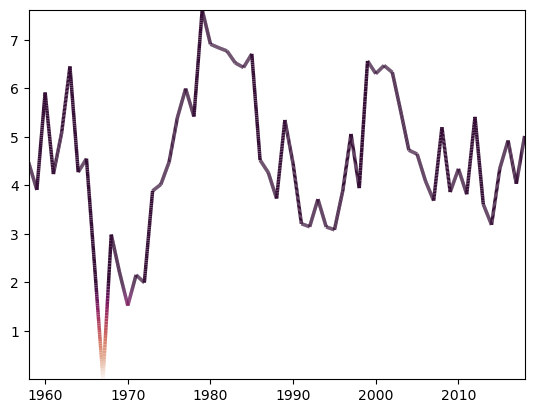

In [21]:
fig, ax = plt.subplots()
x = U_along_annual_binned_CDW_volav.year  # Assuming time is your x-axis
y = (U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[0]) * 100)
#np.linspace(x.min().values,x.max().values,2001)
plotcolors_ASC_annual(ax,x,y,np.abs(2),cmocean.curl)

In [22]:
#yaxis for stacked plots
#plots:     |"a"|"b"  |"c" |"d"  |"e" |"f" |
maxASC  =  [8   ,2   ,0    ,2    ,1   ,-0.8]
minASC  =  [-9  ,-10  ,-18  ,-2 ,-4    ,-2.5  ]
maxPHT  =  [16  ,3   ,15   ,12    ,5   ,13  ]
minPHT  =  [-10 ,-1.5,-2.5 ,-7 ,-2.2,0   ]

#yticks for stacked plots
yticks_ASC = [[0,4,8] , [-2,0,2] , [-8,-4,0] , [0,1,2] , [-1,0,1] , [-1.6,-1.2,-0.8]]
yticks_PHT = [[-10,-5,0,5] , [-1,-0.5,0,0.5] , [-2,0,2,4,6] , [-8,-4,0] , [-2,-1,0,1] , [0,3,6]]

In [23]:
#years wuth eastward anomalies extracted from the compositess
yearsinds=[[1963, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1999, 2001] ,\
[1962, 1968, 1975, 1976, 1982, 1984, 2001, 2002, 2004, 2015],\
[1960, 1961, 1989, 1994, 1995, 1997, 2000, 2001, 2002, 2003]]

In [24]:
seasonal_xticks = [  0    , 31    , 59    , 90    , 119   , 150   ,  180  ,  211  , 242   ,  272  ,  304  , 334   ]
seasonal_xlabels= ['1/Jan','1/Feb','1/Mar','1/Apr','1/May','1/Jun','1/Jul','1/Aug','1/Sep','1/Oct','1/Nov','1/Dec']

testing old figure 4

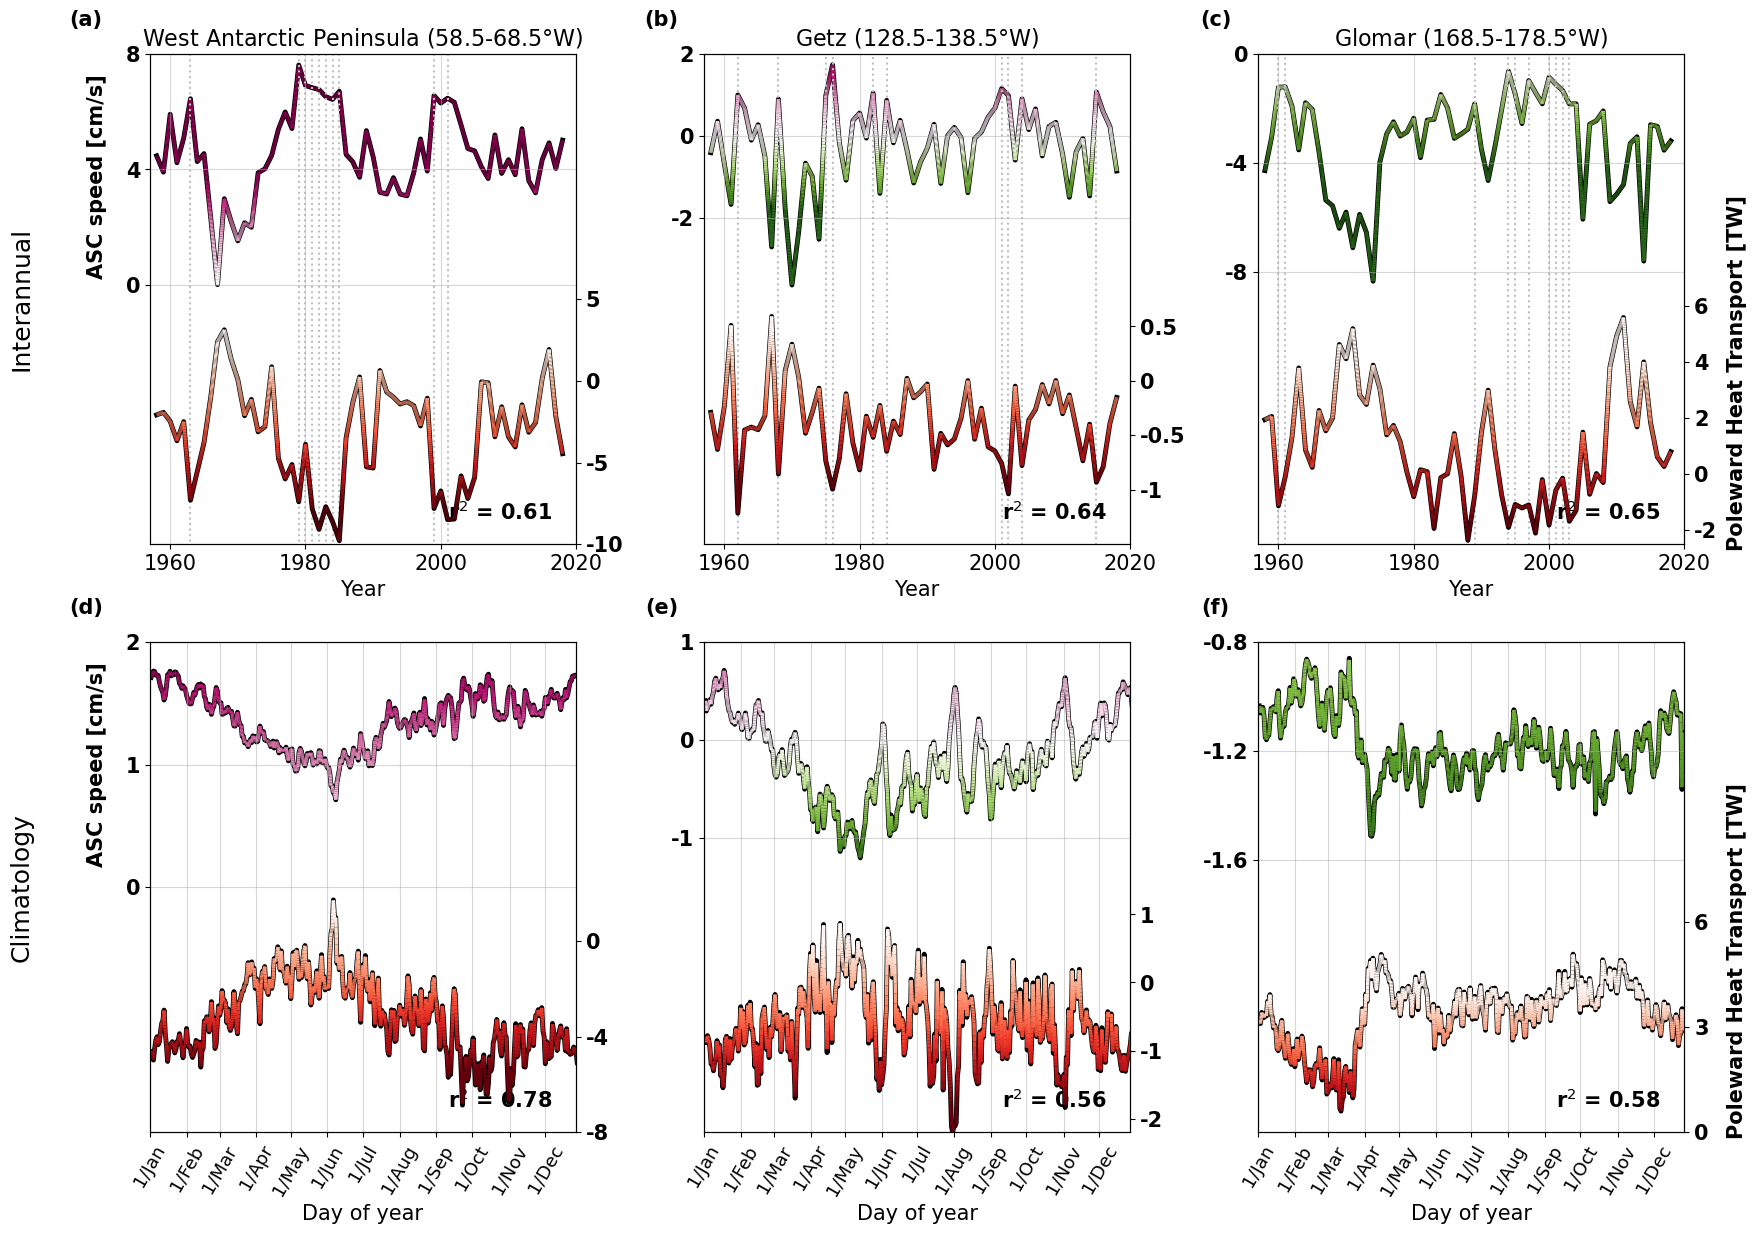

In [25]:
### MOST UPDATED FIGURE 4
## bracket (a) in bold - outside of the box
fontsize=15


fig = plt.figure(figsize=(22*0.9, 14))
ASC_color='black'
CSHT_color='black'
outlinethickness=3.5
# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=2, ncols=3, figure=fig)
grid.update(hspace=0.2, wspace=0.3)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

# Loop through the 3x4 grid to create subplots
for j in range(inds_regions.size):  # Loop over rows

    i = inds_regions[j]

    ax3 = fig.add_subplot(grid[0, j])
    ax4 = fig.add_subplot(grid[1, j])
    ###################
    ax3.set_title(regions[i] + ' (' + str(-longitude_slices[i]-5) + '-' \
                  + str(-longitude_slices[i]+5) + '$\degree$W)',fontsize=16)

    ax3_HT=ax3.twinx()
    ax3.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    x=U_along_annual_binned_CDW_volav.year
    y=(U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_annual(ax3,x,y,(0.5*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    #ax3.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    # ax3.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax3.set_ylim([minASC[j],maxASC[j]])
    
    ax3_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_annual_binned_CDW_volav.year
    y=(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_annual(ax3_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax3_HT.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax3_HT.set_ylim([minPHT[j],maxPHT[j]])
    # ax3.set_ylim(u_along_lims[i])
    # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    if j == 0:
        ax3.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
        ax3.yaxis.set_label_coords(-0.1, 0.75)
    # ax3_HT.set_ylim(CSHT_lims[i])
    # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    if j == inds_regions.size-1:
        ax3_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
        ax3_HT.yaxis.set_label_coords(1.1, 0.35)
    
    ax3.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax3.grid(alpha = 0.5)
    ax3.set_xlim(1957,2020)
    ax3.set_xlabel('Year',fontsize=fontsize)
    ax3.tick_params(axis='y', colors=ASC_color,labelsize=fontsize)  # Left y-axis ticks and labels in blue
    ax3_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize) # Right y-axis ticks and labels in orange
    ax3.plot([yearsinds[j],yearsinds[j]],[np.array(yearsinds[j])*0-30,np.array(yearsinds[j])*0+30],':',color='silver',zorder=0)

    if j == 0:
        ax3.set_yticks(ax3.get_yticks()[1::2])
        ax3_HT.set_yticks(ax3_HT.get_yticks()[::2])
    if j == 1:
        ax3.set_yticks(ax3.get_yticks()[::2])
        ax3_HT.set_yticks(ax3_HT.get_yticks()[::2])        
    if j == 2:
        ax3_HT.set_yticks(ax3_HT.get_yticks()[1::2])

    ax3.set_yticklabels(ax3.get_yticks(), weight='bold')
    ax3_HT.set_yticklabels(ax3_HT.get_yticks(), weight='bold')
    ax3.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_annual_10deg.sel(lon_bins = longitude_slices[i]).values,2)), \
             (0.7,0.05), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)  
    ax3.set_yticks(ticks=yticks_ASC[j],labels=yticks_ASC[j])
    ax3_HT.set_yticks(ticks=yticks_PHT[j],labels=yticks_PHT[j])
    ################
    
    ax4_HT=ax4.twinx()
    ax4.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_clim_daily.sel(lon_bins = longitude_slices[i]).values,2)), \
                 (0.7,0.05), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)    
    
    ax4.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    #ax4.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_clima(ax4,x,y,(1.1*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    # ax4.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax4.set_ylim([minASC[3+j],maxASC[3+j]])
    ax4_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_clima(ax4_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax4_HT.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax4_HT.set_ylim([minPHT[3+j],maxPHT[3+j]])

    if j == 0:    
        ax4.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
        ax4.yaxis.set_label_coords(-0.1, 0.75)
 
    if j == inds_regions.size-1:
        ax4_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
        ax4_HT.yaxis.set_label_coords(1.1, 0.35)
    ax4.set_xlabel('Day of year',fontsize=fontsize)
    #ax4.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50),fontsize=fontsize)
    ax4_HT.set_xticks(ticks=[],labels=[])
    ax4.grid(alpha = 0.5)
    # Set tick colors
    ax4.tick_params(axis='y', colors=ASC_color,labelsize=fontsize) # Left y-axis ticks and labels in blue
    ax4_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize)  # Right y-axis ticks and labels in orange
    ax4_HT.set_xlim(0,360)
    ax4.set_xticks(ticks=seasonal_xticks)
    ax4.set_xticklabels(labels=seasonal_xlabels, fontsize=fontsize-2, rotation=60, ha='center')
    ax4.tick_params(axis='x',labelsize=fontsize-2, labelrotation=60)


    if j == 0:
        ax4_HT.set_yticks(ax4_HT.get_yticks()[:])
        ax4.set_yticks(ax4.get_yticks()[1::2])
    if j == 1:
        ax4.set_yticks(ax4.get_yticks()[1::2])
        ax4_HT.set_yticks(ax4_HT.get_yticks()[1::2])
    if j == 2:
        ax4.set_yticks(ax4.get_yticks()[::2])    
        ax4_HT.set_yticks(ax4_HT.get_yticks()[1::2])


    ax4.set_yticklabels(np.round(ax4.get_yticks(),1), weight='bold')
    ax4_HT.set_yticklabels(ax4_HT.get_yticks(), weight='bold')
    ax4.set_yticks(ticks=yticks_ASC[3+j],labels=yticks_ASC[3+j])
    ax4_HT.set_yticks(ticks=yticks_PHT[3+j],labels=yticks_PHT[3+j])

ax3.text(-2.9,0.5, 'Interannual', fontsize=18, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
ax4.text(-2.9,0.5, 'Climatology', fontsize=18, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)

ax3.text(-2.75,1.07, '(a)', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', fontweight = 'bold')
ax3.text(-1.4,1.07, '(b)', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', fontweight = 'bold')
ax3.text(-0.1,1.07, '(c)', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', fontweight = 'bold')
ax4.text(-2.75,1.07, '(d)', fontsize=fontsize, transform = ax4.transAxes, va = 'center', ha = 'center', fontweight = 'bold')
ax4.text(-1.4,1.07, '(e)', fontsize=fontsize, transform = ax4.transAxes, va = 'center', ha = 'center', fontweight = 'bold')
ax4.text(-0.1,1.07, '(f)', fontsize=fontsize, transform = ax4.transAxes, va = 'center', ha = 'center', fontweight = 'bold')

plt.tight_layout()
#figure_path = '/g/data/x77/wf4500/ASC_project/analysis_figs/selected_time_series_aug4_blacklines.png'
#plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
## Show the plots
plt.tight_layout()
plt.show()


In [26]:
#test of angled transect

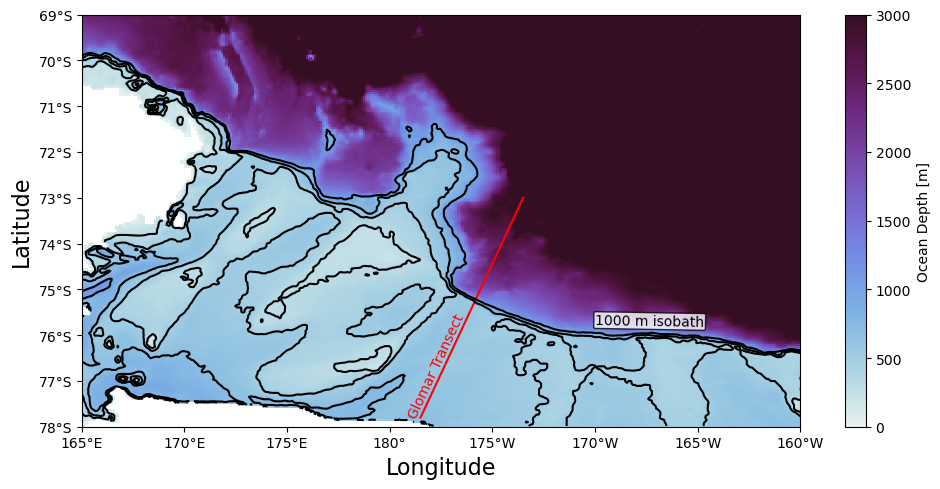

In [27]:
# check location of transect is good:
fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))
# new diagonal, cross-shelf transect:


# define transect start and end points:
lat1 = -77.8
lat0= -73
lon1 = -178.5
lon0 = -173.5

#plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,cmap=cmocean.dense)
plt.colorbar(label = 'Ocean Depth [m]')
plt.clim((0,3000))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')

# plot bathymetry contours:
bath = plt.contour(ht.xt_ocean,ht.yt_ocean.sel(yt_ocean=slice(-78,-69)),ht.sel(yt_ocean=slice(-78,-69)),[300,500,700,1000],colors='k')
#plt.clabel(bath,levels=[1000],inline=True,inline_spacing=1)
plt.text(-170,-75.8,'1000 m isobath',rotation=-1, bbox=dict(facecolor='white',  # Set the face color of the box to white
                  edgecolor='black',  # Optional: Add a black edge to the box
                  boxstyle='round,pad=0.1',  # Define the box style and padding
                  alpha=0.8))
plt.text(-179.2,-77.8,'Glomar Transect',rotation=65,color='red')
ax_cric.xaxis.set_major_formatter(LongitudeFormatter())
ax_cric.yaxis.set_major_formatter(LatitudeFormatter())
plt.ylim(-78,-69)
plt.xlim(-195,-160)
plt.xlabel('Longitude',fontsize = 16)
plt.ylabel('Latitude',fontsize = 16)

plt.tight_layout()


In [28]:
lons = [lon1, lon0]
lats = [lat1, lat0]

yt_ocean = ht.yt_ocean
# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect_t = xr.DataArray(lon_transect, dims = 'yt_ocean')
lon_transect_u = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect_t = xr.DataArray(lat_transect, dims = 'yt_ocean')
lat_transect_u = xr.DataArray(lat_transect, dims = 'yu_ocean')


In [29]:
longitude_slices = np.array([-63.5,-133.5, -173.5])

## Check if high_correlation lons align with the regions we have selected:
print(np.isin(longitude_slices,high_corr_lons))
regions = ['West Antarctic Peninsula', 'Getz', 'Glomar_angled']

min_lat = np.append(np.array([-69, -74.25]), lat0)

vmin_range = np.array([-.2, -.05, -.05])
# for temp:
norm = [col.Normalize(vmin=-1.9,vmax=2.6),
col.Normalize(vmin=-1.8,vmax=1.5), 
col.Normalize(vmin=-1.8,vmax=1.5)]

levels=[np.arange(-1.9,2.6,.05), 
        np.arange(-1.8,1.55,.05), 
        np.arange(-1.8,1.55,.05)]
ticks = [[-1,0,1,2], [-1,0,1], [-1,0,1]]



[ True  True  True]


In [30]:
# import bathymetry:
start_time= '1958-01-01'
end_time= '2018-12-31'
hu_transect_og = importer(exp,catalog,'hu', frequency = 'fx') 
rho_og = importer(exp,catalog,'pot_rho_0',frequency='1mon',start_time=start_time,end_time=end_time,chunks={'time': 12})
#### U importing of iaf by intake has been quite wrong. So I ill import it manually
# u_og = importer(exp,catalog,'u',frequency='1mon',start_time=start_time,end_time=end_time,chunks={'time': 12})
temp_og = importer(exp,catalog,'temp',frequency='1mon',start_time=start_time,end_time=end_time,chunks={'time': 12}) - 273.15

In [31]:
df = catalog[exp].search(variable='u', frequency='1mon').df
print(df["path"])

sel = catalog[exp].search(variable='u', frequency='1mon')
df = sel.df

# Keep only monthly-mean files
df_mean = df[df["filename"].str.contains("monthly-mean")]

0       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-u-1-monthly-mean-ym_1958_01.nc
1      /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-u-1-monthly-pow02-ym_1958_01.nc
2       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output489/ocean/ocean-3d-u-1-monthly-mean-ym_1958_04.nc
3      /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output489/ocean/ocean-3d-u-1-monthly-pow02-ym_1958_04.nc
4       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output490/ocean/ocean-3d-u-1-monthly-mean-ym_1958_07.nc
5      /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output490/ocean/ocean-3d-u-1-monthly-pow02-ym_1958_07.nc
6       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output491/ocean/ocean-3d-u-1-monthly-mean-ym_1958_10.nc
7      /g/data/cj50/

In [38]:
u_og = xr.open_mfdataset(
    df_mean["path"].tolist(),
    combine="by_coords",
    decode_times=True,
    decode_timedelta=True
)["u"]

In [39]:
##########################
hu_transect_list = []
hu_sliced_list = []
max_lat = []
southward_threshold = []
northward_threshold = []
temp_southward = []
temp_northward = []
rho_southward = []
rho_northward = []
u_southward = []
u_northward = []
yearinds = [[np.arange(10)*0],[np.arange(10)*0],[np.arange(10)*0]]
longitude_slices_10dg = [-63.5,-133.5, -173.5]
for i in tqdm(range(longitude_slices.size)):
    print(i)
    # select out longitude:
    u_along_regional = U_along_annual_binned_CDW_volav_f3.U.sel(lon_bins=longitude_slices_10dg[i])
    
    # find u_along threshold for most southward 100 months:
    u_sorted = u_along_regional.sortby(u_along_regional)
    npoints = 10
    southward_threshold.append(u_sorted[npoints].data) #negative, westward threshold for ASC
    northward_threshold.append(u_sorted[-npoints].data) #Positive, eastward threshold for ASC

    ## NOTE: We are now averaging over ten longitude bins

    # import bathymetry:
    if i<2:
        hu_sliced = hu_transect_og.sel(xu_ocean=longitude_slices[i], method='nearest').sel(yu_ocean=lat_range)
        hu_transect = hu_transect_og.sel(xu_ocean=slice(longitude_slices[i]-5, longitude_slices[i]+5)).mean('xu_ocean').sel(yu_ocean=lat_range)
    else:
        hu_sliced = hu_transect_og.sel(xu_ocean=lon_transect_u, yu_ocean = lat_transect_u, method='nearest')

    # fill nans with zeros:
    hu_transect = hu_transect.where(hu_transect>0,0)
    hu_sliced = hu_sliced.where(hu_sliced>0,0)
    hu_transect_list.append(hu_transect)
    hu_sliced_list.append(hu_sliced)
    
    # find latitude limits for plot:
    # lats = (hu_transect.yu_ocean).where(hu_transect>0).compute()
    #min_lat = lats.dropna('yu_ocean').data[0]-.1
    #lats = (hu_transect.yu_ocean).where(hu_transect>3000).compute()
    if i<2:
        lats_2 = (hu_sliced.yu_ocean).where(hu_sliced>3000).compute()
        max_lat.append(lats_2.dropna('yu_ocean').data[0])
    else:
        max_lat.append(lat0)
    if i<2:
        # Use monthly data to pick southward times:
        temp = temp_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
        temp = temp.groupby('time.year').mean().load()
        
        temp_southward.append(temp.where(u_along_regional < southward_threshold[i]).mean('year').load())
        temp_northward.append(temp.where(u_along_regional > northward_threshold[i]).mean('year').load())
        yearinds[i] = u_along_regional.where(u_along_regional >= northward_threshold[i]).dropna(dim='year',how='all').year
        
        
        rho = rho_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
        rho = rho.groupby('time.year').mean().load()
        
        rho_southward.append(rho.where(u_along_regional < southward_threshold[i]).mean('year').load())
        rho_northward.append(rho.where(u_along_regional > northward_threshold[i]).mean('year').load())
        
        u = u_og.sel(time=slice(start_time,end_time)).sel(xu_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yu_ocean=lat_range)
        u = u.groupby('time.year').mean().load()
        
        u_southward.append(u.where(u_along_regional < southward_threshold[i]).mean('year').load())
        u_northward.append(u.where(u_along_regional > northward_threshold[i]).mean('year').load())
    else:
        temp = temp_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_transect_t, yt_ocean = lat_transect_t, method='nearest')\
                                                                   .sel(st_ocean=slice(0,1300))
        temp = temp.groupby('time.year').mean().load()
        temp_southward.append(temp.where(u_along_regional < southward_threshold[i]).mean('year').load())
        temp_northward.append(temp.where(u_along_regional > northward_threshold[i]).mean('year').load())
        yearinds[i] = u_along_regional.where(u_along_regional >= northward_threshold[i]).dropna(dim='year',how='all').year

        rho = rho_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_transect_t, yt_ocean = lat_transect_t, method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300))
        rho = rho.groupby('time.year').mean().load()
        
        rho_southward.append(rho.where(u_along_regional < southward_threshold[i]).mean('year').load())
        rho_northward.append(rho.where(u_along_regional > northward_threshold[i]).mean('year').load())
        
        u = u_og.sel(time=slice(start_time,end_time)).sel(xu_ocean=lon_transect_u, yu_ocean = lat_transect_u, method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300))
        u = u.groupby('time.year').mean().load()
        
        u_southward.append(u.where(u_along_regional < southward_threshold[i]).mean('year').load())
        u_northward.append(u.where(u_along_regional > northward_threshold[i]).mean('year').load())


  0%|          | 0/3 [00:00<?, ?it/s]

0


 33%|███▎      | 1/3 [01:46<03:33, 106.84s/it]

1


 67%|██████▋   | 2/3 [03:35<01:48, 108.02s/it]

2



00%|██████████| 3/3 [04:31<00:00, 90.54s/it] 

In [40]:
arr = np.linspace(-0.03, 0.01, 3)  # Generates 5 points
arr = arr[arr != 0]  # Remove zero
arr

u_levels = [[-.24,-.20,-.16,-.12,-.08,-.04,.04,.08,.12,.16,.20,.24],
            arr, arr]

# density_contours = [[1027.65,1027.78,1027.8],
#                     [1027.65,1027.78,1027.8,1027.82,1027.83],
#                     [1027.7,1027.78, 1027.82]]


density_contours = [[27.65,27.78,27.8],
                    [27.65,27.78,27.8,27.82,27.83],
                    [27.71,27.78, 27.82]]

In [41]:

# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

In [42]:
mean_lon = (lon0+lon1)/2
longitude_slices_forname = longitude_slices.copy()
longitude_slices_forname[-1] = mean_lon

0
-63.51 -61.9
[-64.  -63.5 -63.  -62.5 -62.  -61.5]
['63.5$^\\circ$S', '63.0$^\\circ$S', '62.5$^\\circ$S', '62.0$^\\circ$S']
1
-74.51 -72.9
[-75.  -74.5 -74.  -73.5 -73.  -72.5]
['74.5$^\\circ$S', '74.0$^\\circ$S', '73.5$^\\circ$S', '73.0$^\\circ$S']
2
-76.51 -74.49
[-77.  -76.5 -76.  -75.5 -75.  -74.5 -74. ]
['76.5$^\\circ$S', '76.0$^\\circ$S', '75.5$^\\circ$S', '75.0$^\\circ$S', '74.5$^\\circ$S']


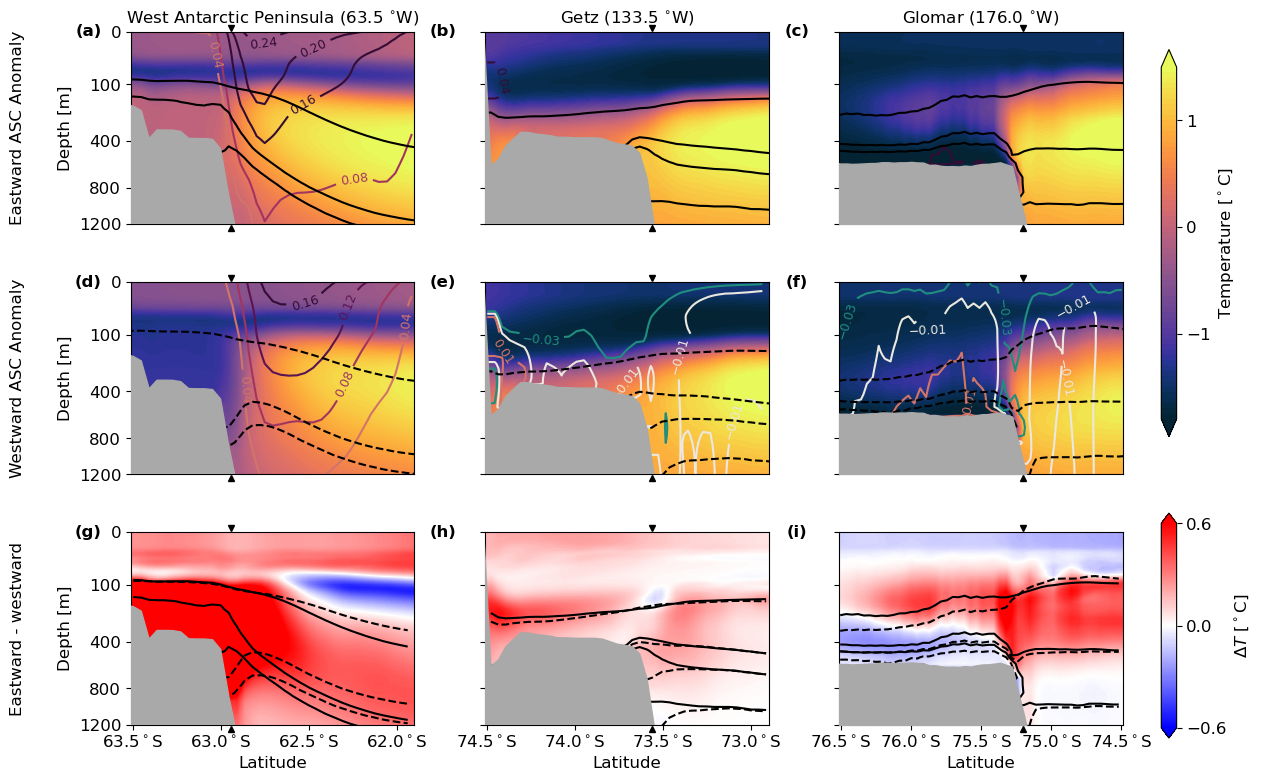

In [43]:

mindepth_plot=0.5
mindepth_plot_label=0
fontsize = 12
lat1_v2=-76.51
isobath_lat=[-62.94,-73.56,-75.2]
#velocity_levels =[-0.03,-0.02,-.01,0.08,0.12,0.16,0.20,0.24]

regions_selected = [ 'West Antarctic Peninsula','Getz', 'Glomar_angled']
regions_forname = [ 'West Antarctic Peninsula','Getz', 'Glomar']
longitude_slices_forname = longitude_slices.copy()
longitude_slices_forname[-1] = mean_lon
# Find indices where regions match those in regions_selected
inds_regions = np.where(np.isin(regions, regions_selected))[0]
min_lats_selected = [-63.51, -74.51, lat1_v2] #it was lat1 before
max_lats_selected = [-61.9, -72.9, -74.49]# Create a figure, the last instance was -73.2 before 
fig = plt.figure(figsize=(16*0.8, 9))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=3, ncols=3, figure=fig)
grid.update(hspace=0.3, wspace=0.25)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Loop through the 3x4 grid to create subplots
for j in range(inds_regions.size):  # Loop over rows
    ax1 = fig.add_subplot(grid[0, j])
    ax2 = fig.add_subplot(grid[1, j])
    ax3 = fig.add_subplot(grid[2, j])

    i = inds_regions[j]
    print(i)
    pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
                       temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both') #norm = norm[i]
    #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax1.set_yscale('function', functions=(forward, inverse))
    ax1.set_ylim(1200,mindepth_plot)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax1.set_ylabel('Depth [m]',fontsize=fontsize)
        ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    ax1.set_xticks([])
    ax1.set_title(str(regions_forname[i])+' ('+str(abs(longitude_slices_forname[i]))+' $^{\circ}$W'+')') #

    # colorbar:
    
    cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    #u_levels[i]
    cont2=ax1.contour(u_northward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),\
                      [0.04,0.08,0.16,0.2,0.24] ,vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax1.clabel(cont2, inline=True, fontsize=9)
    
    cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=0 )
    

    ax1.tick_params(labelsize=fontsize)
    ####################
        
    pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                       temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')#norm = norm[i]
    # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax2.set_yscale('function', functions=(forward, inverse))
    ax2.set_ylim(1200,mindepth_plot)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.set_xticks([])
    print(min_lats_selected[j],max_lats_selected[i])

    if j == 0:
        ax2.set_ylabel('Depth [m]',fontsize=fontsize)
    # ax2.set_xlabel('Latitude',fontsize=fontsize)
    #ax2.set_xticks([-74,-73.5,-73,-72.5])
    #ax2.set_xticks([-66.5,-66,-65.5,-65])
        ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    
    #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)    
    
    cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')
    
    
    cont2=ax2.contour(u_southward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_southward[i].st_ocean,
                     u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.clabel(cont2, inline=True, fontsize=9)
    ax2.tick_params(labelsize=fontsize)
    #########

    pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                   temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
                    temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cm.bwr,levels=np.linspace(-0.6,0.6,200), vmin=-0.6, vmax=0.6, extend='both',fontsize=fontsize)
    ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax3.set_yscale('function', functions=(forward, inverse))
    ax3.set_ylim(1200,mindepth_plot)
    ax3.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax3.set_ylabel('Depth [m]',fontsize=fontsize)
        ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[])

    ax3.set_xlabel('Latitude',fontsize=fontsize)
    print(ax3.get_xticks())
    xticklabels = abs(ax3.get_xticks())[1:-1]
    xticklabels_with_s = [f"{label:.1f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
    print(xticklabels_with_s)
    ax3.set_xticks(ax3.get_xticks()[1:-1])
    ax3.set_xticklabels(xticklabels_with_s)

    ax3.tick_params(labelsize=fontsize)

    cont=ax3.contour(rho_northward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    #ax3.clabel(cont, inline=True, fontsize=9,inline_spacing=5,zorder=400)
    cont=ax3.contour(rho_southward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')

    ax1.text(-0.15,1, subplots[j], fontsize=fontsize, fontweight = 'bold', transform = ax1.transAxes, va = 'center', ha = 'center')
    ax2.text(-0.15,1, subplots[j+3], fontsize=fontsize, fontweight = 'bold', transform = ax2.transAxes, va = 'center', ha = 'center')
    ax3.text(-0.15,1, subplots[j+6], fontsize=fontsize, fontweight = 'bold', transform = ax3.transAxes, va = 'center', ha = 'center')
    # ax1.plot([-80,-50],[1000,1000]); ax1.plot([-62.94,-62.94],[1200,0])# finding the location of the isobath in the plot
    # ax2.plot([-80,-50],[1000,1000]); ax2.plot([-73.56,-73.56],[1200,0])# finding the location of the isobath in the plot
    # ax3.plot([-80,-50],[1000,1000]); ax3.plot([-75.2,-75.2],[1200,0])# finding the location of the isobath in the plot
    ax1.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax1.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)

cax = fig.add_axes([0.93,0.43,0.012,0.43])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
cbar.set_label(r'Temperature [$^\circ$C]',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cax = fig.add_axes([0.93,0.095,0.012,0.25])
cbar = plt.colorbar(pci, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-.6,0,.6])
cbar.set_label(r'$\Delta T$ [$^\circ$C]',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# # colorbar:
# norm_cbar = plt.Normalize(vmin=-.24, vmax = 0.24)
# sm = plt.cm.ScalarMappable(cmap=cmocean.delta, norm = norm_cbar)

# cax = fig.add_axes([0.13,-0.04,0.2,0.022])
# cbar = plt.colorbar(sm, cax=cax,orientation = 'horizontal',extend = 'neither')
# cbar.set_label(r'Velocity Contour [m/s]',fontsize=fontsize,labelpad=5)
# cbar.ax.tick_params(labelsize=fontsize)
# cbar.ax.imshow(
#     np.ones((1, 256, 4)),  # White RGBA image
#     aspect='auto',
#     extent=[0, 1, 0, 1],
#     transform=cbar.ax.transAxes,
#     zorder=1,
#     cmap=matplotlib.colors.ListedColormap(['white'])
# )

# cmap = cmocean.delta         # Replace with your actual colormap

# for level in u_levels[0]:
#     x = norm_cbar(level)
#     color = cmap(x)
#     cbar.ax.vlines(x, 0, 1, color=color, linewidth=4, transform=cbar.ax.transAxes)

# colorbar:
# norm_cbar = plt.Normalize(vmin=-.03, vmax = 0.03)
# sm = plt.cm.ScalarMappable(cmap=cmocean.delta, norm = norm_cbar)

# cax = fig.add_axes([0.4,-0.04,0.5,0.022])
# cbar = plt.colorbar(sm, cax=cax,orientation = 'horizontal',extend = 'neither')
# cbar.set_label(r'Velocity Contour [m/s]',fontsize=fontsize,labelpad=5)
# cbar.ax.tick_params(labelsize=fontsize)
# cbar.ax.imshow(
#     np.ones((1, 256, 4)),  # White RGBA image
#     aspect='auto',
#     extent=[0, 1, 0, 1],
#     transform=cbar.ax.transAxes,
#     zorder=1,
#     cmap=matplotlib.colors.ListedColormap(['white'])
# )

# cmap = cmocean.delta         # Replace with your actual colormap

# for level in u_levels[1]:
#     x = norm_cbar(level)
#     color = cmap(x)
#     cbar.ax.vlines(x, 0, 1, color=color, linewidth=4, transform=cbar.ax.transAxes)

ax1.text(-2.9,0.5, 'Eastward ASC Anomaly', fontsize=fontsize, transform = ax1.transAxes, va = 'center', ha = 'center', rotation = 90)
ax2.text(-2.9,0.5, 'Westward ASC Anomaly', fontsize=fontsize, transform = ax2.transAxes, va = 'center', ha = 'center', rotation = 90)
ax3.text(-2.9,0.5, 'Eastward - westward', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)

# Adjust layout to avoid overlap
plt.tight_layout()
# figure_path = '/g/data/x77/wf4500/ASC_project/analysis_figs/selected_regions_transects_aug19_2025.png'
# plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()

## West Antarctic Peninsula

0
-63.51 -61.9
[-64.  -63.5 -63.  -62.5 -62.  -61.5]
['63.5$^\\circ$S', '63.0$^\\circ$S', '62.5$^\\circ$S', '62.0$^\\circ$S']


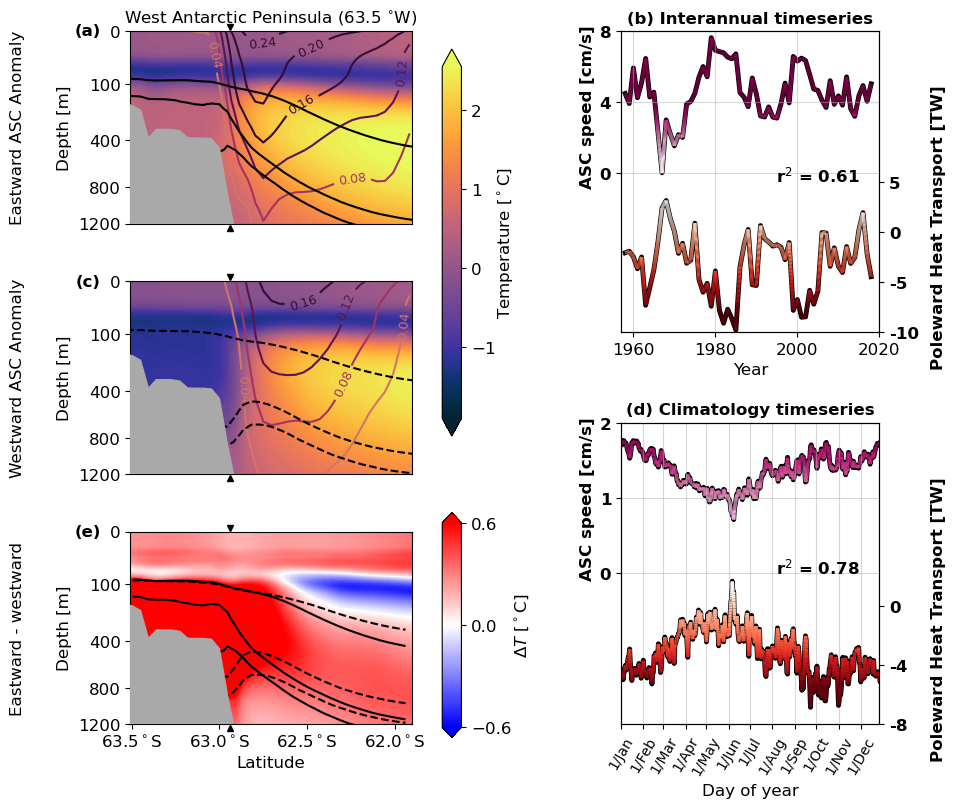

In [44]:
mindepth_plot=0.5
mindepth_plot_label=0
fontsize = 12
lat1_v2=-76.51
isobath_lat=[-62.94,-73.56,-75.2]
#velocity_levels =[-0.03,-0.02,-.01,0.08,0.12,0.16,0.20,0.24]

regions_selected = [ 'West Antarctic Peninsula','Getz', 'Glomar_angled']
regions_forname = [ 'West Antarctic Peninsula','Getz', 'Glomar']
longitude_slices_forname = longitude_slices.copy()
longitude_slices_forname[-1] = mean_lon
# Find indices where regions match those in regions_selected
inds_regions = np.where(np.isin(regions, regions_selected))[0]
min_lats_selected = [-63.51, -74.51, lat1_v2] #it was lat1 before
max_lats_selected = [-61.9, -72.9, -74.49]# Create a figure, the last instance was -73.2 before 
fig = plt.figure(figsize=(16, 9))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=3, ncols=3, figure=fig)
grid.update(hspace=0.3, wspace=0.7)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

subplots = ['(a)', '(b)', '(d)', '(c)', '(g)', '(f)', '(e)', '(h)', '(i)']

# Loop through the 3x4 grid to create subplots
for j in range(1):  # Loop over rows inds_regions.size
    ax1 = fig.add_subplot(grid[0, j])
    ax2 = fig.add_subplot(grid[1, j])
    ax3 = fig.add_subplot(grid[2, j])

    i = inds_regions[j]
    print(i)
    pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
                       temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both') #norm = norm[i]
    #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax1.set_yscale('function', functions=(forward, inverse))
    ax1.set_ylim(1200,mindepth_plot)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax1.set_ylabel('Depth [m]',fontsize=fontsize)
        ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    ax1.set_xticks([])
    ax1.set_title(str(regions_forname[i])+' ('+str(abs(longitude_slices_forname[i]))+' $^{\circ}$W'+')')# \n r$^2$ interannual: '+str(r_sq_annual_10deg.sel(lon_bins=longitude_slices[i]).values.round(2))

    # colorbar:
    
    cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    
    cont2=ax1.contour(u_northward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax1.clabel(cont2, inline=True, fontsize=9)
    
    cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=0 )
    

    ax1.tick_params(labelsize=fontsize)
    ####################
        
    pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                       temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')#norm = norm[i]
    # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax2.set_yscale('function', functions=(forward, inverse))
    ax2.set_ylim(1200,mindepth_plot)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.set_xticks([])
    print(min_lats_selected[j],max_lats_selected[i])

    if j == 0:
        ax2.set_ylabel('Depth [m]',fontsize=fontsize)
    # ax2.set_xlabel('Latitude',fontsize=fontsize)
    #ax2.set_xticks([-74,-73.5,-73,-72.5])
    #ax2.set_xticks([-66.5,-66,-65.5,-65])
        ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    
    #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)    
    
    cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')
    
    [0.04,0.08,0.12,0.16,0.20,0.24]
    cont2=ax2.contour(u_southward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_southward[i].st_ocean,
                     u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),\
                      u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.clabel(cont2, inline=True, fontsize=9)
    ax2.tick_params(labelsize=fontsize)
    #########

    pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                   temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
                    temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cm.bwr,levels=np.linspace(-0.6,0.6,200), vmin=-0.6, vmax=0.6, extend='both',fontsize=fontsize)
    ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax3.set_yscale('function', functions=(forward, inverse))
    ax3.set_ylim(1200,mindepth_plot)
    ax3.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax3.set_ylabel('Depth [m]',fontsize=fontsize)
        ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    else:
        ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[])

    ax3.set_xlabel('Latitude',fontsize=fontsize)
    print(ax3.get_xticks())
    xticklabels = abs(ax3.get_xticks())[1:-1]
    xticklabels_with_s = [f"{label:.1f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
    print(xticklabels_with_s)
    ax3.set_xticks(ax3.get_xticks()[1:-1])
    ax3.set_xticklabels(xticklabels_with_s)

    ax3.tick_params(labelsize=fontsize)

    cont=ax3.contour(rho_northward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    #ax3.clabel(cont, inline=True, fontsize=9,inline_spacing=5,zorder=400)
    cont=ax3.contour(rho_southward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')

    ax1.text(-0.15,1, subplots[j], fontsize=fontsize, fontweight = 'bold', transform = ax1.transAxes, va = 'center', ha = 'center')
    ax2.text(-0.15,1, subplots[j+3], fontsize=fontsize, fontweight = 'bold', transform = ax2.transAxes, va = 'center', ha = 'center')
    ax3.text(-0.15,1, subplots[j+6], fontsize=fontsize, fontweight = 'bold', transform = ax3.transAxes, va = 'center', ha = 'center')
    # ax1.plot([-80,-50],[1000,1000]); ax1.plot([-62.94,-62.94],[1200,0])# finding the location of the isobath in the plot
    # ax2.plot([-80,-50],[1000,1000]); ax2.plot([-73.56,-73.56],[1200,0])# finding the location of the isobath in the plot
    # ax3.plot([-80,-50],[1000,1000]); ax3.plot([-75.2,-75.2],[1200,0])# finding the location of the isobath in the plot
    ax1.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax1.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)



    #########timeseries

    grid = gs.GridSpec(nrows=2, ncols=3, figure=fig)
    grid.update(hspace=0.3, wspace=0.9)
    i = inds_regions[j]
    
    ax333 = fig.add_subplot(grid[0, j+1])
    ax444 = fig.add_subplot(grid[1, j+1])
    ###################
    ax333.set_title(regions[i] + ' (' + str(-longitude_slices[i]-5) + '-' \
                  + str(-longitude_slices[i]+5) + '$\degree$W)',fontsize=16)

    ax333_HT=ax333.twinx()
    ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    x=U_along_annual_binned_CDW_volav.year
    y=(U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_annual(ax333,x,y,(0.5*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    ax333.set_title('(b) Interannual timeseries', fontweight='bold')
    #ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    # ax333.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax333.set_ylim([minASC[j],maxASC[j]])
    
    ax333_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_annual_binned_CDW_volav.year
    y=(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_annual(ax333_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax333_HT.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax333_HT.set_ylim([minPHT[j],maxPHT[j]])
    # ax333.set_ylim(u_along_lims[i])
    # ax333.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    if j == 0:
        ax333.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
        ax333.yaxis.set_label_coords(-0.1, 0.75)
    # ax333_HT.set_ylim(CSHT_lims[i])
    # ax333_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    # if j == inds_regions.size-1:
    ax333_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax333_HT.yaxis.set_label_coords(1.2, 0.35)
    
    ax333.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax333.grid(alpha = 0.5)
    ax333.set_xlim(1957,2020)
    ax333.set_xlabel('Year',fontsize=fontsize)
    ax333.tick_params(axis='y', colors=ASC_color,labelsize=fontsize)  # Left y-axis ticks and labels in blue
    ax333_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize) # Right y-axis ticks and labels in orange
    #ax333.plot([yearsinds[j],yearsinds[j]],[np.array(yearsinds[j])*0-30,np.array(yearsinds[j])*0+30],':',color='silver',zorder=0)

    if j == 0:
        ax333.set_yticks(ax333.get_yticks()[1::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])
    if j == 1:
        ax333.set_yticks(ax333.get_yticks()[::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])        
    if j == 2:
        ax333_HT.set_yticks(ax333_HT.get_yticks()[1::2])

    ax333.set_yticklabels(ax333.get_yticks(), weight='bold')
    ax333_HT.set_yticklabels(ax333_HT.get_yticks(), weight='bold')
    ax333.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_annual_10deg.sel(lon_bins = longitude_slices[i]).values,2)), \
             (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)  
    ax333.set_yticks(ticks=yticks_ASC[j],labels=yticks_ASC[j])
    ax333_HT.set_yticks(ticks=yticks_PHT[j],labels=yticks_PHT[j])
    ################
    
    ax444_HT=ax444.twinx()
    ax444.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_clim_daily.sel(lon_bins = longitude_slices[i]).values,2)), \
                 (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)    
    
    ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    #ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_clima(ax444,x,y,(1.1*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    # ax444.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax444.set_ylim([minASC[3+j],maxASC[3+j]])
    ax444_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_clima(ax444_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax444_HT.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax444_HT.set_ylim([minPHT[3+j],maxPHT[3+j]])
    ax444.set_title('(d) Climatology timeseries', fontweight='bold')

    if j == 0:    
        ax444.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
        ax444.yaxis.set_label_coords(-0.1, 0.75)
 
    # if j == inds_regions.size-1:
    ax444_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax444_HT.yaxis.set_label_coords(1.2, 0.35)
    ax444.set_xlabel('Day of year',fontsize=fontsize)
    #ax444.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50),fontsize=fontsize)
    ax444_HT.set_xticks(ticks=[],labels=[])
    ax444.grid(alpha = 0.5)
    # Set tick colors
    ax444.tick_params(axis='y', colors=ASC_color,labelsize=fontsize) # Left y-axis ticks and labels in blue
    ax444_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize)  # Right y-axis ticks and labels in orange
    ax444_HT.set_xlim(0,360)
    ax444.set_xticks(ticks=seasonal_xticks)
    ax444.set_xticklabels(labels=seasonal_xlabels, fontsize=fontsize-2, rotation=60, ha='center')
    ax444.tick_params(axis='x',labelsize=fontsize-2, labelrotation=60)


    if j == 0:
        ax444_HT.set_yticks(ax444_HT.get_yticks()[:])
        ax444.set_yticks(ax444.get_yticks()[1::2])
    if j == 1:
        ax444.set_yticks(ax444.get_yticks()[1::2])
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])
    if j == 2:
        ax444.set_yticks(ax444.get_yticks()[::2])    
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])


    ax444.set_yticklabels(np.round(ax444.get_yticks(),1), weight='bold')
    ax444_HT.set_yticklabels(ax444_HT.get_yticks(), weight='bold')
    ax444.set_yticks(ticks=yticks_ASC[3+j],labels=yticks_ASC[3+j])
    ax444_HT.set_yticks(ticks=yticks_PHT[3+j],labels=yticks_PHT[3+j])




ax3.text(2,0.5, 'Interannual', fontsize=18, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
ax4.text(2,0.5, 'Climatology', fontsize=18, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)





cax = fig.add_axes([0.32,0.43,0.012,0.43])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
cbar.set_label(r'Temperature [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)

cax = fig.add_axes([0.32,0.095,0.012,0.25])
cbar = plt.colorbar(pci, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-.6,0,.6])
cbar.set_label(r'$\Delta T$ [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)


ax1.text(-.4,0.5, 'Eastward ASC Anomaly', fontsize=fontsize, transform = ax1.transAxes, va = 'center', ha = 'center', rotation = 90)
ax2.text(-.4,0.5, 'Westward ASC Anomaly', fontsize=fontsize, transform = ax2.transAxes, va = 'center', ha = 'center', rotation = 90)
ax3.text(-.4,0.5, 'Eastward - westward', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)

# Adjust layout to avoid overlap
plt.tight_layout()
figure_path = '/g/data/x77/wf4500/ASC_project/analysis_figs/WAP_2025.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()

## Getz

1
-74.51 -72.9
[-75.  -74.5 -74.  -73.5 -73.  -72.5]
['74.5$^\\circ$S', '74.0$^\\circ$S', '73.5$^\\circ$S', '73.0$^\\circ$S']


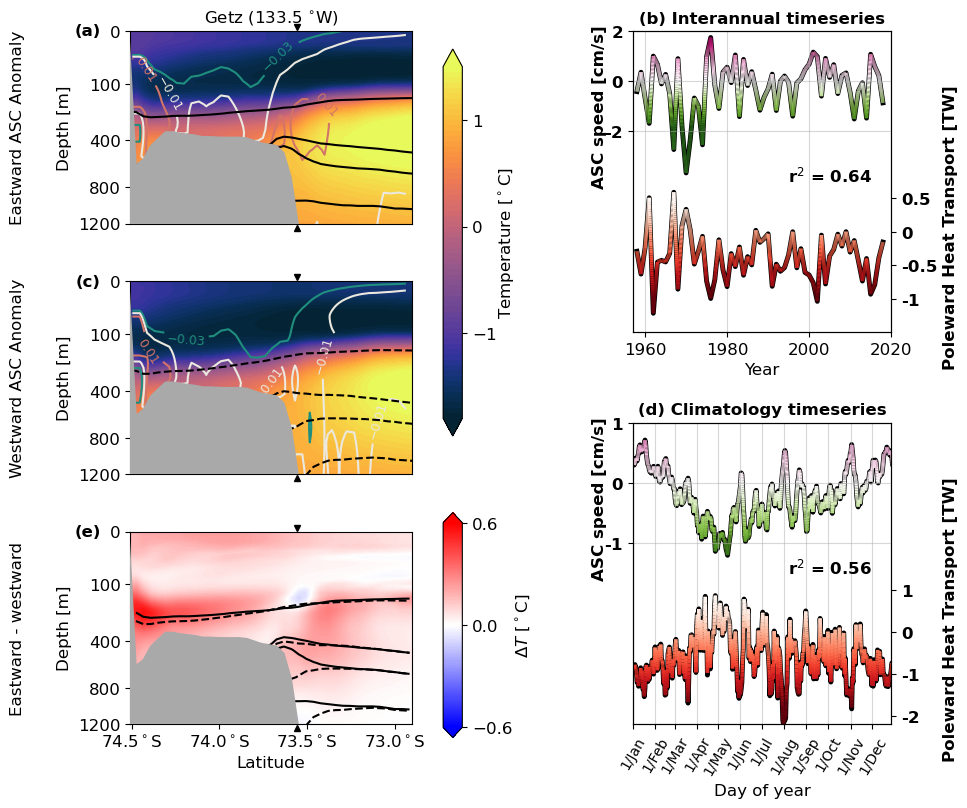

In [45]:
mindepth_plot=0.5
mindepth_plot_label=0
fontsize = 12
lat1_v2=-76.51
isobath_lat=[-62.94,-73.56,-75.2]
#velocity_levels =[-0.03,-0.02,-.01,0.08,0.12,0.16,0.20,0.24]

regions_selected = [ 'West Antarctic Peninsula','Getz', 'Glomar_angled']
regions_forname = [ 'West Antarctic Peninsula','Getz', 'Glomar']
longitude_slices_forname = longitude_slices.copy()
longitude_slices_forname[-1] = mean_lon
# Find indices where regions match those in regions_selected
inds_regions = np.where(np.isin(regions, regions_selected))[0]
min_lats_selected = [-63.51, -74.51, lat1_v2] #it was lat1 before
max_lats_selected = [-61.9, -72.9, -74.49]# Create a figure, the last instance was -73.2 before 
fig = plt.figure(figsize=(16, 9))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=3, ncols=3, figure=fig)
grid.update(hspace=0.3, wspace=0.7)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

subplots = ['(b)', '(a)', '(d)', '(g)', '(c)', '(f)', '(h)', '(e)', '(i)']

# Loop through the 3x4 grid to create subplots
for j in range(1,2):  # Loop over rows inds_regions.size
    ax1 = fig.add_subplot(grid[0, j])
    ax2 = fig.add_subplot(grid[1, j])
    ax3 = fig.add_subplot(grid[2, j])

    i = inds_regions[j]
    print(i)
    pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
                       temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both') #norm = norm[i]
    #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax1.set_yscale('function', functions=(forward, inverse))
    ax1.set_ylim(1200,mindepth_plot)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])

    ax1.set_ylabel('Depth [m]',fontsize=fontsize)
    ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    ax1.set_xticks([])
    ax1.set_title(str(regions_forname[i])+' ('+str(abs(longitude_slices_forname[i]))+' $^{\circ}$W'+')')# \n r$^2$ interannual: '+str(r_sq_annual_10deg.sel(lon_bins=longitude_slices[i]).values.round(2))

    # colorbar:
    
    cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    
    cont2=ax1.contour(u_northward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax1.clabel(cont2, inline=True, fontsize=9)
    
    cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=0 )
    

    ax1.tick_params(labelsize=fontsize)
    ####################
        
    pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                       temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')#norm = norm[i]
    # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax2.set_yscale('function', functions=(forward, inverse))
    ax2.set_ylim(1200,mindepth_plot)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.set_xticks([])
    print(min_lats_selected[j],max_lats_selected[i])


    ax2.set_ylabel('Depth [m]',fontsize=fontsize)
    # ax2.set_xlabel('Latitude',fontsize=fontsize)
    #ax2.set_xticks([-74,-73.5,-73,-72.5])
    #ax2.set_xticks([-66.5,-66,-65.5,-65])
    ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    
    #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)    
    
    cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')
    
    
    cont2=ax2.contour(u_southward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_southward[i].st_ocean,
                     u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.clabel(cont2, inline=True, fontsize=9)
    ax2.tick_params(labelsize=fontsize)
    #########

    pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                   temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
                    temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cm.bwr,levels=np.linspace(-0.6,0.6,200), vmin=-0.6, vmax=0.6, extend='both',fontsize=fontsize)
    ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax3.set_yscale('function', functions=(forward, inverse))
    ax3.set_ylim(1200,mindepth_plot)
    ax3.set_xlim(min_lats_selected[j],max_lats_selected[i])
    # if j == 0:
    ax3.set_ylabel('Depth [m]',fontsize=fontsize)
    ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[])

    ax3.set_xlabel('Latitude',fontsize=fontsize)
    print(ax3.get_xticks())
    xticklabels = abs(ax3.get_xticks())[1:-1]
    xticklabels_with_s = [f"{label:.1f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
    print(xticklabels_with_s)
    ax3.set_xticks(ax3.get_xticks()[1:-1])
    ax3.set_xticklabels(xticklabels_with_s)

    ax3.tick_params(labelsize=fontsize)

    cont=ax3.contour(rho_northward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    #ax3.clabel(cont, inline=True, fontsize=9,inline_spacing=5,zorder=400)
    cont=ax3.contour(rho_southward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')

    ax1.text(-0.15,1, subplots[j], fontsize=fontsize, fontweight = 'bold', transform = ax1.transAxes, va = 'center', ha = 'center')
    ax2.text(-0.15,1, subplots[j+3], fontsize=fontsize, fontweight = 'bold', transform = ax2.transAxes, va = 'center', ha = 'center')
    ax3.text(-0.15,1, subplots[j+6], fontsize=fontsize, fontweight = 'bold', transform = ax3.transAxes, va = 'center', ha = 'center')
    # ax1.plot([-80,-50],[1000,1000]); ax1.plot([-62.94,-62.94],[1200,0])# finding the location of the isobath in the plot
    # ax2.plot([-80,-50],[1000,1000]); ax2.plot([-73.56,-73.56],[1200,0])# finding the location of the isobath in the plot
    # ax3.plot([-80,-50],[1000,1000]); ax3.plot([-75.2,-75.2],[1200,0])# finding the location of the isobath in the plot
    ax1.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax1.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)



    #########timeseries

    grid = gs.GridSpec(nrows=2, ncols=3, figure=fig)
    grid.update(hspace=0.3, wspace=0.9)
    i = inds_regions[j]
    
    ax333 = fig.add_subplot(grid[0, j+1])
    ax444 = fig.add_subplot(grid[1, j+1])
    ###################
    ax333.set_title(regions[i] + ' (' + str(-longitude_slices[i]-5) + '-' \
                  + str(-longitude_slices[i]+5) + '$\degree$W)',fontsize=16)

    ax333_HT=ax333.twinx()
    ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    x=U_along_annual_binned_CDW_volav.year
    y=(U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_annual(ax333,x,y,(0.5*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    ax333.set_title('(b) Interannual timeseries', fontweight='bold')
    #ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    # ax333.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax333.set_ylim([minASC[j],maxASC[j]])
    
    ax333_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_annual_binned_CDW_volav.year
    y=(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_annual(ax333_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax333_HT.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax333_HT.set_ylim([minPHT[j],maxPHT[j]])
    # ax333.set_ylim(u_along_lims[i])
    # ax333.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')

    ax333.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
    ax333.yaxis.set_label_coords(-0.1, 0.75)
    # ax333_HT.set_ylim(CSHT_lims[i])
    # ax333_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    # if j == inds_regions.size-1:
    ax333_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax333_HT.yaxis.set_label_coords(1.2, 0.35)
    
    ax333.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax333.grid(alpha = 0.5)
    ax333.set_xlim(1957,2020)
    ax333.set_xlabel('Year',fontsize=fontsize)
    ax333.tick_params(axis='y', colors=ASC_color,labelsize=fontsize)  # Left y-axis ticks and labels in blue
    ax333_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize) # Right y-axis ticks and labels in orange
    #ax333.plot([yearsinds[j],yearsinds[j]],[np.array(yearsinds[j])*0-30,np.array(yearsinds[j])*0+30],':',color='silver',zorder=0)

    if j == 0:
        ax333.set_yticks(ax333.get_yticks()[1::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])
    if j == 1:
        ax333.set_yticks(ax333.get_yticks()[::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])        
    if j == 2:
        ax333_HT.set_yticks(ax333_HT.get_yticks()[1::2])

    ax333.set_yticklabels(ax333.get_yticks(), weight='bold')
    ax333_HT.set_yticklabels(ax333_HT.get_yticks(), weight='bold')
    ax333.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_annual_10deg.sel(lon_bins = longitude_slices[i]).values,2)), \
             (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)  
    ax333.set_yticks(ticks=yticks_ASC[j],labels=yticks_ASC[j])
    ax333_HT.set_yticks(ticks=yticks_PHT[j],labels=yticks_PHT[j])
    ################
    
    ax444_HT=ax444.twinx()
    ax444.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_clim_daily.sel(lon_bins = longitude_slices[i]).values,2)), \
                 (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)    
    
    ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    #ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_clima(ax444,x,y,(1.1*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    # ax444.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax444.set_ylim([minASC[3+j],maxASC[3+j]])
    ax444_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_clima(ax444_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax444_HT.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax444_HT.set_ylim([minPHT[3+j],maxPHT[3+j]])
    ax444.set_title('(d) Climatology timeseries', fontweight='bold')


    ax444.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
    ax444.yaxis.set_label_coords(-0.1, 0.75)
 
    # if j == inds_regions.size-1:
    ax444_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax444_HT.yaxis.set_label_coords(1.2, 0.35)
    ax444.set_xlabel('Day of year',fontsize=fontsize)
    #ax444.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50),fontsize=fontsize)
    ax444_HT.set_xticks(ticks=[],labels=[])
    ax444.grid(alpha = 0.5)
    # Set tick colors
    ax444.tick_params(axis='y', colors=ASC_color,labelsize=fontsize) # Left y-axis ticks and labels in blue
    ax444_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize)  # Right y-axis ticks and labels in orange
    ax444_HT.set_xlim(0,360)
    ax444.set_xticks(ticks=seasonal_xticks)
    ax444.set_xticklabels(labels=seasonal_xlabels, fontsize=fontsize-2, rotation=60, ha='center')
    ax444.tick_params(axis='x',labelsize=fontsize-2, labelrotation=60)


    if j == 0:
        ax444_HT.set_yticks(ax444_HT.get_yticks()[:])
        ax444.set_yticks(ax444.get_yticks()[1::2])
    if j == 1:
        ax444.set_yticks(ax444.get_yticks()[1::2])
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])
    if j == 2:
        ax444.set_yticks(ax444.get_yticks()[::2])    
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])


    ax444.set_yticklabels(np.round(ax444.get_yticks(),1), weight='bold')
    ax444_HT.set_yticklabels(ax444_HT.get_yticks(), weight='bold')
    ax444.set_yticks(ticks=yticks_ASC[3+j],labels=yticks_ASC[3+j])
    ax444_HT.set_yticks(ticks=yticks_PHT[3+j],labels=yticks_PHT[3+j])




ax3.text(2,0.5, 'Interannual', fontsize=18, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
ax4.text(2,0.5, 'Climatology', fontsize=18, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)





cax = fig.add_axes([0.62,0.43,0.012,0.43])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
cbar.set_label(r'Temperature [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)

cax = fig.add_axes([0.62,0.095,0.012,0.25])
cbar = plt.colorbar(pci, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-.6,0,.6])
cbar.set_label(r'$\Delta T$ [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)


ax1.text(-.4,0.5, 'Eastward ASC Anomaly', fontsize=fontsize, transform = ax1.transAxes, va = 'center', ha = 'center', rotation = 90)
ax2.text(-.4,0.5, 'Westward ASC Anomaly', fontsize=fontsize, transform = ax2.transAxes, va = 'center', ha = 'center', rotation = 90)
ax3.text(-.4,0.5, 'Eastward - westward', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)

# Adjust layout to avoid overlap
plt.tight_layout()
figure_path = '/g/data/x77/wf4500/ASC_project/analysis_figs/Getz_2025.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()

## Glomar

2
-76.51 -74.49
[-77.  -76.5 -76.  -75.5 -75.  -74.5 -74. ]
['76.5$^\\circ$S', '76.0$^\\circ$S', '75.5$^\\circ$S', '75.0$^\\circ$S', '74.5$^\\circ$S']


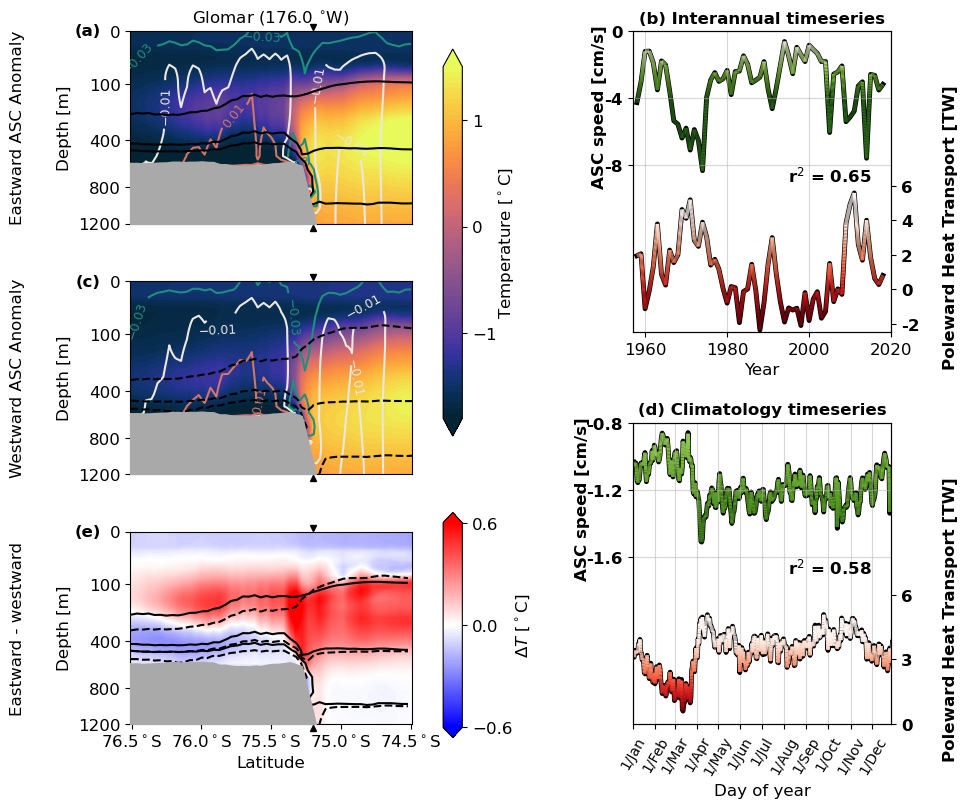

In [46]:
mindepth_plot=0.5
mindepth_plot_label=0
fontsize = 12
lat1_v2=-76.51
isobath_lat=[-62.94,-73.56,-75.2]
#velocity_levels =[-0.03,-0.02,-.01,0.08,0.12,0.16,0.20,0.24]

regions_selected = [ 'West Antarctic Peninsula','Getz', 'Glomar_angled']
regions_forname = [ 'West Antarctic Peninsula','Getz', 'Glomar']
longitude_slices_forname = longitude_slices.copy()
longitude_slices_forname[-1] = mean_lon
# Find indices where regions match those in regions_selected
inds_regions = np.where(np.isin(regions, regions_selected))[0]
min_lats_selected = [-63.51, -74.51, lat1_v2] #it was lat1 before
max_lats_selected = [-61.9, -72.9, -74.49]# Create a figure, the last instance was -73.2 before 
fig = plt.figure(figsize=(16, 9))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=3, ncols=3, figure=fig)
grid.update(hspace=0.3, wspace=0.7)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

subplots = ['(b)', '(d)', '(a)', '(g)', '(f)', '(c)', '(h)', '(i)', '(e)']

# Loop through the 3x4 grid to create subplots
for j in range(2,3):  # Loop over rows inds_regions.size
    ax1 = fig.add_subplot(grid[0, j-1])
    ax2 = fig.add_subplot(grid[1, j-1])
    ax3 = fig.add_subplot(grid[2, j-1])

    i = inds_regions[j]
    print(i)
    pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
                       temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both') #norm = norm[i]
    #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax1.set_yscale('function', functions=(forward, inverse))
    ax1.set_ylim(1200,mindepth_plot)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])

    ax1.set_ylabel('Depth [m]',fontsize=fontsize)
    ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax1.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    ax1.set_xticks([])
    ax1.set_title(str(regions_forname[i])+' ('+str(abs(longitude_slices_forname[i]))+' $^{\circ}$W'+')')# \n r$^2$ interannual: '+str(r_sq_annual_10deg.sel(lon_bins=longitude_slices[i]).values.round(2))

    # colorbar:
    
    cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    
    cont2=ax1.contour(u_northward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax1.clabel(cont2, inline=True, fontsize=9)
    
    cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=0 )
    

    ax1.tick_params(labelsize=fontsize)
    ####################
        
    pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                       temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')#norm = norm[i]
    # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax2.set_yscale('function', functions=(forward, inverse))
    ax2.set_ylim(1200,mindepth_plot)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.set_xticks([])
    print(min_lats_selected[j],max_lats_selected[i])


    ax2.set_ylabel('Depth [m]',fontsize=fontsize)
    # ax2.set_xlabel('Latitude',fontsize=fontsize)
    #ax2.set_xticks([-74,-73.5,-73,-72.5])
    #ax2.set_xticks([-66.5,-66,-65.5,-65])
    ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax2.set_yticks([1200,800,400,100,mindepth_plot],labels=[])
    
    #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)    
    
    cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')
    
    
    cont2=ax2.contour(u_southward[i].yu_ocean.sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_southward[i].st_ocean,
                     u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate').sel(yu_ocean=slice(min_lats_selected[j],max_lats_selected[i])),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i]*0.7,
                      cmap=cmocean.curl,zorder=2 ,fontsize=fontsize)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.clabel(cont2, inline=True, fontsize=9)
    ax2.tick_params(labelsize=fontsize)
    #########

    pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                   temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
                    temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cm.bwr,levels=np.linspace(-0.6,0.6,200), vmin=-0.6, vmax=0.6, extend='both',fontsize=fontsize)
    ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax3.set_yscale('function', functions=(forward, inverse))
    ax3.set_ylim(1200,mindepth_plot)
    ax3.set_xlim(min_lats_selected[j],max_lats_selected[i])
    # if j == 0:
    ax3.set_ylabel('Depth [m]',fontsize=fontsize)
    ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[1200,800,400,100,mindepth_plot_label])
    # else:
    #     ax3.set_yticks([1200,800,400,100,mindepth_plot],labels=[])

    ax3.set_xlabel('Latitude',fontsize=fontsize)
    print(ax3.get_xticks())
    xticklabels = abs(ax3.get_xticks())[1:-1]
    xticklabels_with_s = [f"{label:.1f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
    print(xticklabels_with_s)
    ax3.set_xticks(ax3.get_xticks()[1:-1])
    ax3.set_xticklabels(xticklabels_with_s)

    ax3.tick_params(labelsize=fontsize)

    cont=ax3.contour(rho_northward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    #ax3.clabel(cont, inline=True, fontsize=9,inline_spacing=5,zorder=400)
    cont=ax3.contour(rho_southward[i].yt_ocean.sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i])),rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate').sel(yt_ocean=slice(min_lats_selected[j],max_lats_selected[i]))-1000,density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')

    ax1.text(-0.15,1, subplots[j], fontsize=fontsize, fontweight = 'bold', transform = ax1.transAxes, va = 'center', ha = 'center')
    ax2.text(-0.15,1, subplots[j+3], fontsize=fontsize, fontweight = 'bold', transform = ax2.transAxes, va = 'center', ha = 'center')
    ax3.text(-0.15,1, subplots[j+6], fontsize=fontsize, fontweight = 'bold', transform = ax3.transAxes, va = 'center', ha = 'center')
    # ax1.plot([-80,-50],[1000,1000]); ax1.plot([-62.94,-62.94],[1200,0])# finding the location of the isobath in the plot
    # ax2.plot([-80,-50],[1000,1000]); ax2.plot([-73.56,-73.56],[1200,0])# finding the location of the isobath in the plot
    # ax3.plot([-80,-50],[1000,1000]); ax3.plot([-75.2,-75.2],[1200,0])# finding the location of the isobath in the plot
    ax1.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax1.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax2.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 0, marker='v', color='black', markersize=5,clip_on=False)
    ax3.plot(isobath_lat[i], 1250, marker='^', color='black', markersize=5,clip_on=False)



    #########timeseries

    grid = gs.GridSpec(nrows=2, ncols=3, figure=fig)
    grid.update(hspace=0.3, wspace=0.9)
    i = inds_regions[j]
    
    ax333 = fig.add_subplot(grid[0, j])
    ax444 = fig.add_subplot(grid[1, j])
    ###################
    ax333.set_title(regions[i] + ' (' + str(-longitude_slices[i]-5) + '-' \
                  + str(-longitude_slices[i]+5) + '$\degree$W)',fontsize=16)

    ax333_HT=ax333.twinx()
    ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    x=U_along_annual_binned_CDW_volav.year
    y=(U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_annual(ax333,x,y,(0.5*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    ax333.set_title('(b) Interannual timeseries', fontweight='bold')
    #ax333.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    # ax333.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax333.set_ylim([minASC[j],maxASC[j]])
    
    ax333_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_annual_binned_CDW_volav.year
    y=(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_annual(ax333_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax333_HT.plot([1956,2024],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax333_HT.set_ylim([minPHT[j],maxPHT[j]])
    # ax333.set_ylim(u_along_lims[i])
    # ax333.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')

    ax333.set_ylabel('ASC speed [cm/s]',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
    ax333.yaxis.set_label_coords(-0.1, 0.75)
    # ax333_HT.set_ylim(CSHT_lims[i])
    # ax333_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    # if j == inds_regions.size-1:
    ax333_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax333_HT.yaxis.set_label_coords(1.2, 0.35)
    
    ax333.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax333.grid(alpha = 0.5)
    ax333.set_xlim(1957,2020)
    ax333.set_xlabel('Year',fontsize=fontsize)
    ax333.tick_params(axis='y', colors=ASC_color,labelsize=fontsize)  # Left y-axis ticks and labels in blue
    ax333_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize) # Right y-axis ticks and labels in orange
    #ax333.plot([yearsinds[j],yearsinds[j]],[np.array(yearsinds[j])*0-30,np.array(yearsinds[j])*0+30],':',color='silver',zorder=0)

    if j == 0:
        ax333.set_yticks(ax333.get_yticks()[1::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])
    if j == 1:
        ax333.set_yticks(ax333.get_yticks()[::2])
        ax333_HT.set_yticks(ax333_HT.get_yticks()[::2])        
    if j == 2:
        ax333_HT.set_yticks(ax333_HT.get_yticks()[1::2])

    ax333.set_yticklabels(ax333.get_yticks(), weight='bold')
    ax333_HT.set_yticklabels(ax333_HT.get_yticks(), weight='bold')
    ax333.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_annual_10deg.sel(lon_bins = longitude_slices[i]).values,2)), \
             (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)  
    ax333.set_yticks(ticks=yticks_ASC[j],labels=yticks_ASC[j])
    ax333_HT.set_yticks(ticks=yticks_PHT[j],labels=yticks_PHT[j])
    ################
    
    ax444_HT=ax444.twinx()
    ax444.annotate( 'r$^{2}$ = ' + str(np.round(r_sq_clim_daily.sel(lon_bins = longitude_slices[i]).values,2)), \
                 (0.6,0.5), xycoords='axes fraction', fontsize = fontsize, fontweight = 'bold', zorder = 600)    
    
    ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC',linewidth=outlinethickness,zorder=0,color=ASC_color)
    #ax444.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_DSW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='DSW',color='k')
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)
    plotcolors_ASC_clima(ax444,x,y,(1.1*np.max(np.abs(y))).values,'PiYG_r')#np.max(np.abs(y)).values
    # ax444.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:blue')
    ax444.set_ylim([minASC[3+j],maxASC[3+j]])
    ax444_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color=CSHT_color,linewidth=outlinethickness,zorder=0)
    x=U_along_clima_binned_CDW_volav.dayofyear
    y=(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12)
    plotcolors_CSHT_clima(ax444_HT,x,y,np.max(np.abs(y)).values,'Reds_r')
    # ax444_HT.plot([0,365],[0,0],\
    #          linestyle='--',color='tab:orange')
    ax444_HT.set_ylim([minPHT[3+j],maxPHT[3+j]])
    ax444.set_title('(d) Climatology timeseries', fontweight='bold')


    ax444.set_ylabel('ASC speed [cm/s]\n',fontsize=fontsize,color=ASC_color, fontweight = 'bold')
    ax444.yaxis.set_label_coords(-0.1, 0.75)
 
    # if j == inds_regions.size-1:
    ax444_HT.set_ylabel('Poleward Heat Transport [TW]',fontsize=fontsize,color=CSHT_color, fontweight = 'bold')
    ax444_HT.yaxis.set_label_coords(1.2, 0.35)
    ax444.set_xlabel('Day of year',fontsize=fontsize)
    #ax444.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50),fontsize=fontsize)
    ax444_HT.set_xticks(ticks=[],labels=[])
    ax444.grid(alpha = 0.5)
    # Set tick colors
    ax444.tick_params(axis='y', colors=ASC_color,labelsize=fontsize) # Left y-axis ticks and labels in blue
    ax444_HT.tick_params(axis='y', colors=CSHT_color,labelsize=fontsize)  # Right y-axis ticks and labels in orange
    ax444_HT.set_xlim(0,360)
    ax444.set_xticks(ticks=seasonal_xticks)
    ax444.set_xticklabels(labels=seasonal_xlabels, fontsize=fontsize-2, rotation=60, ha='center')
    ax444.tick_params(axis='x',labelsize=fontsize-2, labelrotation=60)


    if j == 0:
        ax444_HT.set_yticks(ax444_HT.get_yticks()[:])
        ax444.set_yticks(ax444.get_yticks()[1::2])
    if j == 1:
        ax444.set_yticks(ax444.get_yticks()[1::2])
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])
    if j == 2:
        ax444.set_yticks(ax444.get_yticks()[::2])    
        ax444_HT.set_yticks(ax444_HT.get_yticks()[1::2])


    ax444.set_yticklabels(np.round(ax444.get_yticks(),1), weight='bold')
    ax444_HT.set_yticklabels(ax444_HT.get_yticks(), weight='bold')
    ax444.set_yticks(ticks=yticks_ASC[3+j],labels=yticks_ASC[3+j])
    ax444_HT.set_yticks(ticks=yticks_PHT[3+j],labels=yticks_PHT[3+j])




ax3.text(2,0.5, 'Interannual', fontsize=18, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
ax4.text(2,0.5, 'Climatology', fontsize=18, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)





cax = fig.add_axes([0.62,0.43,0.012,0.43])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
cbar.set_label(r'Temperature [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)

cax = fig.add_axes([0.62,0.095,0.012,0.25])
cbar = plt.colorbar(pci, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-.6,0,.6])
cbar.set_label(r'$\Delta T$ [$^\circ$C]',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)


ax1.text(-.4,0.5, 'Eastward ASC Anomaly', fontsize=fontsize, transform = ax1.transAxes, va = 'center', ha = 'center', rotation = 90)
ax2.text(-.4,0.5, 'Westward ASC Anomaly', fontsize=fontsize, transform = ax2.transAxes, va = 'center', ha = 'center', rotation = 90)
ax3.text(-.4,0.5, 'Eastward - westward', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)

# Adjust layout to avoid overlap
plt.tight_layout()
figure_path = '/g/data/x77/wf4500/ASC_project/analysis_figs/Glomar_2025.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()